In [12]:
import os.path

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
model = torchvision.models.mobilenet_v2(pretrained=True)

In [15]:
# for param in model.parameters():
#     param.requires_grad = False

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
dataset = torchvision.datasets.ImageFolder(root="data", transform=transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2),
#     nn.Linear(model.last_channel, 4)
# )
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [21]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [22]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    epoch_accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(epoch_accuracy_train)
    
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    epoch_accuracy_val = 100 * correct_val / total_val
    val_accuracies.append(epoch_accuracy_val)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy_train:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy_val:.2f}%')


Epoch [1/10], Train Loss: 3.4391, Train Accuracy: 52.63%, Val Loss: 0.9474, Val Accuracy: 82.54%
Epoch [2/10], Train Loss: 0.5260, Train Accuracy: 90.09%, Val Loss: 0.4768, Val Accuracy: 88.76%
Epoch [3/10], Train Loss: 0.3105, Train Accuracy: 93.22%, Val Loss: 0.3788, Val Accuracy: 89.23%
Epoch [4/10], Train Loss: 0.2435, Train Accuracy: 93.94%, Val Loss: 0.3673, Val Accuracy: 89.47%
Epoch [5/10], Train Loss: 0.1939, Train Accuracy: 94.57%, Val Loss: 0.3102, Val Accuracy: 89.95%
Epoch [6/10], Train Loss: 0.1676, Train Accuracy: 95.22%, Val Loss: 0.2953, Val Accuracy: 90.19%
Epoch [7/10], Train Loss: 0.1341, Train Accuracy: 96.15%, Val Loss: 0.2750, Val Accuracy: 90.19%
Epoch [8/10], Train Loss: 0.1245, Train Accuracy: 96.24%, Val Loss: 0.2667, Val Accuracy: 90.19%
Epoch [9/10], Train Loss: 0.1050, Train Accuracy: 96.84%, Val Loss: 0.2544, Val Accuracy: 90.67%
Epoch [10/10], Train Loss: 0.0996, Train Accuracy: 96.72%, Val Loss: 0.2401, Val Accuracy: 91.39%


In [30]:
test_correct = 0
test_total = 0
true_labels = []
predicted_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 96.19%


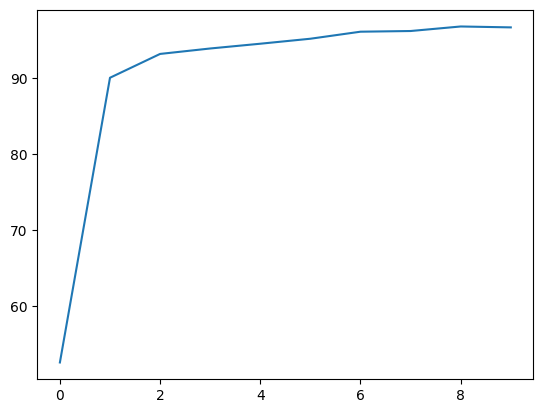

In [26]:
plt.plot(train_accuracies)

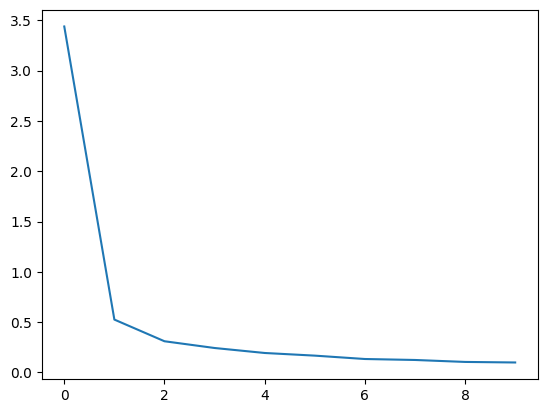

In [27]:
plt.plot(train_losses)

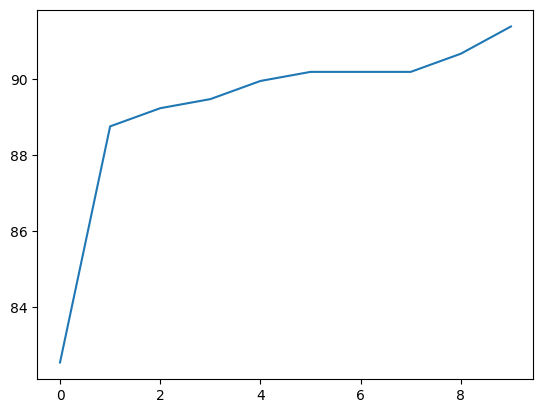

In [28]:
plt.plot(val_accuracies)

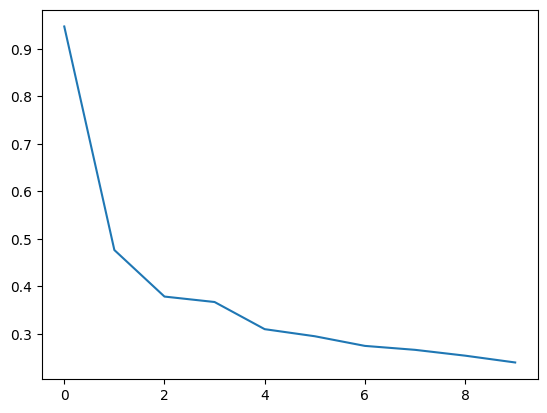

In [29]:
plt.plot(val_losses)

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(conf_matrix)

[[ 98   1   5   0]
 [  3 118   2   0]
 [  4   1  48   0]
 [  0   0   0 140]]


In [35]:

class_names = ["Blight", "Common_Rust", "Gray_Leaf_Spot", "Healthy"]

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(class_report)

                precision    recall  f1-score   support

        Blight       0.93      0.94      0.94       104
   Common_Rust       0.98      0.96      0.97       123
Gray_Leaf_Spot       0.87      0.91      0.89        53
       Healthy       1.00      1.00      1.00       140

      accuracy                           0.96       420
     macro avg       0.95      0.95      0.95       420
  weighted avg       0.96      0.96      0.96       420
